# RL for Channel Selection
## Top-level simulation script

## Define functions to allow importing from Jupyter notebooks
Ref: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

NB: This code should be moved to a utility library.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

## Begin main simulation run script.

In [3]:
from env import Env
from RL_brain import DeepQNetwork

## Simulation configuration parameters

In [4]:
sim = {
    'cfg' : {
        'run' : { # run parameters
            'numEpisodes'    : 10,  # num. of episodes to run
            'maxSteps'       : 2000, # max. num. of sim. steps
            'startLearnStep' : 200,  # start periodic training after this step num.
            'learnPeriod'    : 5,    # num. of steps between (re)training
        },
        'dqn' : { # DQN parameters
            'learningRate'      : 0.01, # please provide summary comments for each parameter
            'rewardDecay'       : 0.9,
            'eGreedy'           : 0.9,
            'replaceTargetIter' : 200,
            'memorySize'        : 2000,
        }
    }
}

## The run() command runs the main simulation loop.

In [5]:
def run():
    # For ease of access to run parameters.
    step = 0
    numEpisodes = sim['cfg']['run']['numEpisodes']
    maxSteps = sim['cfg']['run']['maxSteps']
    startLearnStep = sim['cfg']['run']['startLearnStep']
    learnPeriod = sim['cfg']['run']['learnPeriod']
    
    for episode in range(numEpisodes):
        # initial observation
        step = 0
        env_state_1 = env.reset()
        while step < maxSteps:
            # fresh env

            # Output current observation:
            #print('{}: current env = {}\n'.format(env.time, env.__dict__))
            print('{}: current env = {}\n'.format(env.time,env.time_env_state))
            env_state = np.hstack((env_state_1["Channel_1"], env_state_1["Channel_6"],
                                   env_state_1["Channel_11"]))
            # RL choose action based on env_state
            action = RL.choose_action(env_state)
            if action == 0:
                action_ = "Channel_1"
            elif action == 1:
                action_ = "Channel_6"
            else:
                action_ = "Channel_11"
            observation = env_state_1[action_]
            print('{}: action_ = {}, observation = {}\n'.format(env.time, action_, observation))
            # print(observation)
            # RL take action and get next observation and reward
            env_state_, observation_, reward = env.step(action_)
            env_state_ = np.hstack(( env_state_["Channel_1"],  env_state_["Channel_6"],
                                      env_state_["Channel_11"]))


            RL.store_transition(env_state, action, reward, env_state_)

            if (step > startLearnStep) and (step % learnPeriod == 0):
                RL.learn()
            env_state_={"Channel_1":env_state_[0:4],
                        "Channel_6":env_state_[4:8],
                        "Channel_11":env_state_[8:12]

            }

            # swap observation
            #observation = observation_
            env_state_1 = env_state_

            # break while loop when end of this episode
            step += 1


## Main simulation routine

Instructions for updating:
Colocations handled automatically by placer.
2: current env = {'current': {'Channel_1': array([-92.        , -45.        ,  30.        ,  21.43728157]), 'Channel_6': array([-53.        , -96.        ,  24.        ,  95.23096556]), 'Channel_11': array([-32.        , -20.        ,  20.        ,  15.60324833])}}

2: action_ = Channel_1, observation = [-92.         -45.          30.          21.43728157]

2: action Channel_1 has max. value 153.56263178171736

2: selected action = Channel_1 with max. value, reward = 1

3: current env = {'current': {'Channel_1': array([-97.       , -81.       ,  20.       ,  39.1335019]), 'Channel_6': array([-87.        ,  -3.        ,  27.        ,  59.85509773]), 'Channel_11': array([-88.        , -30.        ,  30.        ,  68.38093952])}}

3: action_ = Channel_1, observation = [-97.        -81.         20.         39.1335019]

3: action Channel_1 has max. value 161.75875584475563

3: selected action = Channel_1 with max. value


49: current env = {'current': {'Channel_1': array([-68.        , -23.        ,  24.        ,  76.03233697]), 'Channel_6': array([ -9.        , -13.        ,  20.        ,   2.05617386]), 'Channel_11': array([-78.        , -11.        ,  20.        ,  45.65877489])}}

49: action_ = Channel_1, observation = [-68.         -23.          24.          76.03233697]

49: action Channel_6 has max. value 125.48842150784367

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
50: current env = {'current': {'Channel_1': array([-16.        , -26.        ,  27.        ,  84.30409934]), 'Channel_6': array([-95.        , -25.        ,  24.        ,   3.26628738]), 'Channel_11': array([-39.        ,  -5.        ,  24.        ,  64.82512262])}}

50: action_ = Channel_11, observation = [-39.          -5.          24.          64.82512262]

50: action Channel_6 has max. value 145.7337121854162

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
51: current env = {'current': {'Channel_1': array([-98.        , -88.        ,  24.        , 

155: current env = {'current': {'Channel_1': array([-74.      , -34.      ,  24.      ,  63.143114]), 'Channel_6': array([ -1.        , -79.        ,  27.        ,  14.31287124]), 'Channel_11': array([-71.        , -24.        ,  24.        ,  32.81148735])}}

155: action_ = Channel_1, observation = [-74.       -34.        24.        63.143114]

155: action Channel_11 has max. value 115.18842600181476

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
156: current env = {'current': {'Channel_1': array([-64.        , -71.        ,  30.        ,  67.95308367]), 'Channel_6': array([-80.        , -92.        ,  30.        ,  78.18562145]), 'Channel_11': array([-51.        , -57.        ,  30.        ,  97.73903799])}}

156: action_ = Channel_1, observation = [-64.         -71.          30.          67.95308367]

156: action Channel_6 has max. value 131.54865479606127

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
157: current env = {'current': {'Channel_1': array([-41.        , -89.        ,  20.        ,  22.43155

208: current env = {'current': {'Channel_1': array([-18.        , -22.        ,  20.        ,  36.42867097]), 'Channel_6': array([-79.        , -47.        ,  24.        ,  76.31351868]), 'Channel_11': array([-20.       , -76.       ,  30.       ,  79.9085671])}}

208: action_ = Channel_6, observation = [-79.         -47.          24.          76.31351868]

208: action Channel_1 has max. value 100.11592439769643

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
209: current env = {'current': {'Channel_1': array([-41.        ,  -9.        ,  27.        ,  61.03986511]), 'Channel_6': array([-17.        , -52.        ,  20.        ,  87.46385848]), 'Channel_11': array([-57.        , -52.        ,  20.        ,  66.45156325])}}

209: action_ = Channel_1, observation = [-41.          -9.          27.          61.03986511]

209: action Channel_11 has max. value 104.35512626767262

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
210: current env = {'current': {'Channel_1': array([-42.        , -96.        ,  27.       

303: action_ = Channel_11, observation = [-11.         -97.          24.          11.49278271]

303: action Channel_11 has max. value 123.50721727891613

303: selected action = Channel_11 with max. value, reward = 1

304: current env = {'current': {'Channel_1': array([-59.        , -58.        ,  20.        ,  77.24560757]), 'Channel_6': array([-32.        , -71.        ,  20.        ,  18.71731788]), 'Channel_11': array([-92.        , -92.        ,  20.        ,  88.03468105])}}

304: action_ = Channel_1, observation = [-59.         -58.          20.          77.24560757]

304: action Channel_6 has max. value 133.28213541243886

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
305: current env = {'current': {'Channel_1': array([-62.        , -33.        ,  27.        ,  24.02035814]), 'Channel_6': array([-86.        , -58.        ,  30.        ,   6.33267086]), 'Channel_11': array([-79.        , -13.        ,  27.        ,  49.72507034])}}

305: action_ = Channel_1, observation = [-62.         -33.

394: action_ = Channel_11, observation = [-20.         -53.          20.          47.76545402]

394: action Channel_1 has max. value 130.5809804861807

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
395: current env = {'current': {'Channel_1': array([-18.        , -87.        ,  20.        ,  93.77373923]), 'Channel_6': array([ -5.        , -26.        ,  27.        ,   5.36283093]), 'Channel_11': array([-51.        , -16.        ,  20.        ,  25.49023645])}}

395: action_ = Channel_11, observation = [-51.         -16.          20.          25.49023645]

395: action Channel_6 has max. value 126.60280811976799

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
396: current env = {'current': {'Channel_1': array([  0.        , -50.        ,  24.        ,  27.41129962]), 'Channel_6': array([-95.        , -17.        ,  24.        ,   5.86942615]), 'Channel_11': array([-32.       ,  -4.       ,  27.       ,  32.3912537])}}

396: action_ = Channel_6, observation = [-95.         -17.          24.           5.8694261

486: action_ = Channel_11, observation = [-93.         -81.          27.          32.45917031]

486: action Channel_11 has max. value 175.27510593695234

486: selected action = Channel_11 with max. value, reward = 1

487: current env = {'current': {'Channel_1': array([-23.        , -14.        ,  30.        ,  68.43939006]), 'Channel_6': array([ -5.       , -79.       ,  30.       ,  68.8656718]), 'Channel_11': array([-19.        , -39.        ,  20.        ,  14.80372631])}}

487: action_ = Channel_11, observation = [-19.         -39.          20.          14.80372631]

487: action Channel_11 has max. value 124.15305995441784

487: selected action = Channel_11 with max. value, reward = 1

488: current env = {'current': {'Channel_1': array([-51.       , -16.       ,  20.       ,  77.7384532]), 'Channel_6': array([-98.        ,  -8.        ,  24.        ,  11.72309176]), 'Channel_11': array([-91.        , -92.        ,  30.        ,  23.86722905])}}

488: action_ = Channel_1, observatio


576: selected action = Channel_1 with max. value, reward = 1

577: current env = {'current': {'Channel_1': array([-61.        , -61.        ,  20.        ,   5.88979563]), 'Channel_6': array([-38.        , -15.        ,  20.        ,  16.49248271]), 'Channel_11': array([-52.        , -21.        ,  30.        ,   0.29033093])}}

577: action_ = Channel_11, observation = [-52.         -21.          30.           0.29033093]

577: action Channel_1 has max. value 172.09990441715598

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
578: current env = {'current': {'Channel_1': array([-69.        , -91.        ,  27.        ,  32.99294182]), 'Channel_6': array([-79.        , -63.        ,  27.        ,  71.78634027]), 'Channel_11': array([-12.        , -37.        ,  20.        ,  23.08515219])}}

578: action_ = Channel_1, observation = [-69.         -91.          27.          32.99294182]

578: action Channel_1 has max. value 162.97974213884135

578: selected action = Channel_1 with max. value, reward = 

669: action_ = Channel_1, observation = [-92.         -23.          20.           7.90046191]

669: action Channel_1 has max. value 135.09953754691247

669: selected action = Channel_1 with max. value, reward = 1

670: current env = {'current': {'Channel_1': array([-81.        , -26.        ,  20.        ,  34.90489133]), 'Channel_6': array([-75.        , -42.        ,  20.        ,  55.51495178]), 'Channel_11': array([-48.        , -80.        ,  27.        ,   7.98018047])}}

670: action_ = Channel_11, observation = [-48.         -80.          27.           7.98018047]

670: action Channel_11 has max. value 167.01708018397528

670: selected action = Channel_11 with max. value, reward = 1

671: current env = {'current': {'Channel_1': array([-93.        , -70.        ,  30.        ,  45.14940314]), 'Channel_6': array([-64.        , -34.        ,  27.        ,  22.49479653]), 'Channel_11': array([-84.        , -72.        ,  24.        ,  30.19634457])}}

671: action_ = Channel_11, obse

762: current env = {'current': {'Channel_1': array([-50.      , -81.      ,  20.      ,  19.805383]), 'Channel_6': array([-22.        , -55.        ,  27.        ,  50.49271504]), 'Channel_11': array([-93.        , -57.        ,  27.        ,  69.89213718])}}

762: action_ = Channel_11, observation = [-93.         -57.          27.          69.89213718]

762: action Channel_1 has max. value 150.19116864759408

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
763: current env = {'current': {'Channel_1': array([-82.        , -93.        ,  24.        ,  67.46848989]), 'Channel_6': array([-45.       , -43.       ,  24.       ,  75.6173799]), 'Channel_11': array([-95.        , -45.        ,  24.        ,  52.50275076])}}

763: action_ = Channel_11, observation = [-95.         -45.          24.          52.50275076]

763: action Channel_1 has max. value 138.19955390816932

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
764: current env = {'current': {'Channel_1': array([-56.        ,   0.        ,  24.        ,  78.

846: action_ = Channel_11, observation = [ -59.         -100.           30.           49.03460394]

846: action Channel_11 has max. value 139.96505110438292

846: selected action = Channel_11 with max. value, reward = 1

847: current env = {'current': {'Channel_1': array([-73.        , -60.        ,  30.        ,  35.91220688]), 'Channel_6': array([-19.        , -50.        ,  30.        ,  63.91458378]), 'Channel_11': array([-14.        ,  -6.        ,  27.        ,  64.29736274])}}

847: action_ = Channel_11, observation = [-14.          -6.          27.          64.29736274]

847: action Channel_1 has max. value 153.8754091016967

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
848: current env = {'current': {'Channel_1': array([-66.        , -44.        ,  27.        ,  65.68883396]), 'Channel_6': array([-70.        , -11.        ,  20.        ,  85.93801254]), 'Channel_11': array([-37.        , -35.        ,  20.        ,  58.20480165])}}

848: action_ = Channel_11, observation = [-37.        

937: action_ = Channel_11, observation = [-46.         -27.          24.          93.15395749]

937: action Channel_1 has max. value 131.4217907719471

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
938: current env = {'current': {'Channel_1': array([-11.        , -29.        ,  20.        ,  33.76812882]), 'Channel_6': array([-12.        , -53.        ,  27.        ,  69.91555196]), 'Channel_11': array([-56.        , -31.        ,  30.        ,  89.72876436])}}

938: action_ = Channel_11, observation = [-56.         -31.          30.          89.72876436]

938: action Channel_1 has max. value 97.16357989355923

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
939: current env = {'current': {'Channel_1': array([-12.        , -22.        ,  24.        ,  20.97449671]), 'Channel_6': array([-22.        , -58.        ,  30.        ,   1.74742651]), 'Channel_11': array([-38.        , -37.        ,  24.        ,  12.86323296])}}

939: action_ = Channel_11, observation = [-38.         -37.          24.          12.863

1023: current env = {'current': {'Channel_1': array([-56.        , -30.        ,  30.        ,  70.33202581]), 'Channel_6': array([-31.        , -67.        ,  30.        ,  53.42551631]), 'Channel_11': array([-43.        , -56.        ,  24.        ,  99.84322265])}}

1023: action_ = Channel_11, observation = [-43.         -56.          24.          99.84322265]

1023: action Channel_6 has max. value 107.57339293113344

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1024: current env = {'current': {'Channel_1': array([-12.        , -27.        ,  24.        ,  67.45449684]), 'Channel_6': array([-97.        , -83.        ,  27.        ,  18.56368574]), 'Channel_11': array([-53.        , -92.        ,  20.        ,  63.00665429])}}

1024: action_ = Channel_11, observation = [-53.         -92.          20.          63.00665429]

1024: action Channel_6 has max. value 191.2667713640909

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1025: current env = {'current': {'Channel_1': array([-51.        , -72.        , 


1095: action_ = Channel_6, observation = [-100.          -31.           30.           89.40680161]

1095: action Channel_11 has max. value 176.7555477751601

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1096: current env = {'current': {'Channel_1': array([-83.        , -99.        ,  30.        ,  55.05826834]), 'Channel_6': array([ -5.        , -63.        ,  30.        ,  58.55457327]), 'Channel_11': array([-21.        , -32.        ,  27.        ,  38.86486008])}}

1096: action_ = Channel_6, observation = [ -5.         -63.          30.          58.55457327]

1096: action Channel_1 has max. value 157.83398940046445

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1097: current env = {'current': {'Channel_1': array([-35.        ,  -2.        ,  24.        ,  18.51193911]), 'Channel_6': array([-82.        , -15.        ,  24.        ,  85.18765447]), 'Channel_11': array([-23.        , -94.        ,  30.        ,  50.84220256])}}

1097: action_ = Channel_6, observation = [-82.         -15.          24.     

1159: action_ = Channel_6, observation = [-58.         -68.          30.          97.64832914]

1159: action Channel_11 has max. value 133.48255966146894

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1160: current env = {'current': {'Channel_1': array([-86.        , -26.        ,  30.        ,  40.82482526]), 'Channel_6': array([-86.        , -96.        ,  20.        ,  80.49182645]), 'Channel_11': array([-53.        , -43.        ,  27.        ,  38.86808609])}}

1160: action_ = Channel_6, observation = [-86.         -96.          20.          80.49182645]

1160: action Channel_11 has max. value 130.71798705471286

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1161: current env = {'current': {'Channel_1': array([-82.        ,  -7.        ,  20.        ,  91.95618822]), 'Channel_6': array([-19.        , -43.        ,  30.        ,  25.56674652]), 'Channel_11': array([ -1.        , -82.        ,  30.        ,  41.70348256])}}

1161: action_ = Channel_6, observation = [-19.         -43.          30.        


1215: action_ = Channel_6, observation = [-74.         -4.         27.         53.5266445]

1215: action Channel_6 has max. value 77.47335506522292

1215: selected action = Channel_6 with max. value, reward = 1

1216: current env = {'current': {'Channel_1': array([-67.        , -80.        ,  24.        ,  50.86217809]), 'Channel_6': array([-74.        ,  -6.        ,  27.        ,  57.88516303]), 'Channel_11': array([-52.        , -14.        ,  27.        ,  59.63162376])}}

1216: action_ = Channel_6, observation = [-74.          -6.          27.          57.88516303]

1216: action Channel_1 has max. value 139.92543788828016

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1217: current env = {'current': {'Channel_1': array([ -57.        , -100.        ,   30.        ,   15.24337789]), 'Channel_6': array([-54.        , -95.        ,  24.        ,  40.16564621]), 'Channel_11': array([-10.        , -58.        ,  27.        ,  32.25032415])}}

1217: action_ = Channel_6, observation = [-54.        

1308: action_ = Channel_6, observation = [-44.         -78.          24.           9.03827138]

1308: action Channel_6 has max. value 158.96000001076675

1308: selected action = Channel_6 with max. value, reward = 1

1309: current env = {'current': {'Channel_1': array([-69.        , -82.        ,  30.        ,  85.41879683]), 'Channel_6': array([-42.        ,  -5.        ,  30.        ,  40.17496448]), 'Channel_11': array([-100.        ,  -10.        ,   27.        ,    6.16656378])}}

1309: action_ = Channel_6, observation = [-42.          -5.          30.          40.17496448]

1309: action Channel_11 has max. value 130.83343621440525

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1310: current env = {'current': {'Channel_1': array([-11.        , -82.        ,  30.        ,  67.87347852]), 'Channel_6': array([-79.        ,  -5.        ,  27.        ,  28.53335931]), 'Channel_11': array([ -1.        , -80.        ,  30.        ,  94.55628111])}}

1310: action_ = Channel_6, observation = [-79.   

1395: action_ = Channel_6, observation = [-35.         -73.          27.           4.78484292]

1395: action Channel_11 has max. value 179.16419658990517

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1396: current env = {'current': {'Channel_1': array([-59.        , -78.        ,  20.        ,  29.29596916]), 'Channel_6': array([-17.        ,  -3.        ,  24.        ,  90.41454078]), 'Channel_11': array([ -21.        , -100.        ,   30.        ,   39.97631789])}}

1396: action_ = Channel_6, observation = [-17.          -3.          24.          90.41454078]

1396: action Channel_1 has max. value 149.64969770015233

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1397: current env = {'current': {'Channel_1': array([-22.        , -32.        ,  27.        ,  21.01354434]), 'Channel_6': array([-42.        , -88.        ,  24.        ,  90.64193797]), 'Channel_11': array([-63.        , -35.        ,  20.        ,  27.96764206])}}

1397: action_ = Channel_6, observation = [-42.         -88.          24.     

1487: action_ = Channel_6, observation = [-39.          -3.          30.          79.41490682]

1487: action Channel_11 has max. value 76.4595248655464

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1488: current env = {'current': {'Channel_1': array([-99.        , -59.        ,  20.        ,  45.89168893]), 'Channel_6': array([-69.        , -84.        ,  27.        ,  56.65875984]), 'Channel_11': array([-12.        , -88.        ,  30.        ,   9.66600753])}}

1488: action_ = Channel_6, observation = [-69.         -84.          27.          56.65875984]

1488: action Channel_6 has max. value 139.20603093936515

1488: selected action = Channel_6 with max. value, reward = 1

1489: current env = {'current': {'Channel_1': array([-92.        , -32.        ,  27.        ,  64.17253105]), 'Channel_6': array([-86.        , -20.        ,  24.        ,   1.03671873]), 'Channel_11': array([-67.        , -41.        ,  27.        ,  95.60513709])}}

1489: action_ = Channel_6, observation = [-86.         

1578: current env = {'current': {'Channel_1': array([-68.        , -50.        ,  30.        ,  15.19160667]), 'Channel_6': array([-42.        , -81.        ,  24.        ,  26.99691185]), 'Channel_11': array([ -5.        , -35.        ,  24.        ,  26.02394134])}}

1578: action_ = Channel_6, observation = [-42.         -81.          24.          26.99691185]

1578: action Channel_1 has max. value 164.74010204644074

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1579: current env = {'current': {'Channel_1': array([-10.        , -83.        ,  24.        ,  76.38117339]), 'Channel_6': array([-67.        , -14.        ,  20.        ,   7.16671653]), 'Channel_11': array([-85.        , -61.        ,  30.        ,   5.17531611])}}

1579: action_ = Channel_1, observation = [-10.         -83.          24.          76.38117339]

1579: action Channel_11 has max. value 185.80742863802107

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1580: current env = {'current': {'Channel_1': array([-62.        , -32.        , 

1665: action_ = Channel_6, observation = [-15.         -87.          30.          22.86023639]

1665: action Channel_6 has max. value 122.13976333967818

1665: selected action = Channel_6 with max. value, reward = 1

1666: current env = {'current': {'Channel_1': array([-51.        , -42.        ,  30.        ,  82.68745129]), 'Channel_6': array([ -9.        , -23.        ,  30.        ,  59.97430148]), 'Channel_11': array([-36.        , -51.        ,  30.        ,  59.63106044])}}

1666: action_ = Channel_6, observation = [ -9.         -23.          30.          59.97430148]

1666: action Channel_11 has max. value 106.23373033607766

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1667: current env = {'current': {'Channel_1': array([ -9.        , -54.        ,  27.        ,  48.41959819]), 'Channel_6': array([-14.        , -53.        ,  27.        ,  22.21015431]), 'Channel_11': array([ -6.        , -42.        ,  27.        ,  63.87372416])}}

1667: action_ = Channel_6, observation = [-14.       

1730: action_ = Channel_6, observation = [-64.         -76.          27.          42.89906905]

1730: action Channel_1 has max. value 152.88205953305987

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1731: current env = {'current': {'Channel_1': array([ -8.        , -38.        ,  24.        ,  39.25611838]), 'Channel_6': array([ -7.        , -64.        ,  24.        ,  17.11190102]), 'Channel_11': array([ -56.        , -100.        ,   24.        ,   30.71634479])}}

1731: action_ = Channel_6, observation = [ -7.         -64.          24.          17.11190102]

1731: action Channel_11 has max. value 149.28348231711794

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1732: current env = {'current': {'Channel_1': array([ -1.        , -25.        ,  27.        ,  48.28054215]), 'Channel_6': array([-82.        , -41.        ,  27.        ,  71.86524887]), 'Channel_11': array([-65.        , -83.        ,  30.        ,  48.21113911])}}

1732: action_ = Channel_6, observation = [-82.         -41.          27.     

1784: action_ = Channel_6, observation = [-79.         -27.          27.          72.97980211]

1784: action Channel_1 has max. value 104.23821738493383

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1785: current env = {'current': {'Channel_1': array([-97.        ,  -8.        ,  27.        ,  57.18337884]), 'Channel_6': array([-80.        , -55.        ,  30.        ,  47.16332939]), 'Channel_11': array([-65.        , -21.        ,  30.        ,  15.53553923])}}

1785: action_ = Channel_6, observation = [-80.         -55.          30.          47.16332939]

1785: action Channel_6 has max. value 137.82295868586385

1785: selected action = Channel_6 with max. value, reward = 1

1786: current env = {'current': {'Channel_1': array([  0.        , -52.        ,  24.        ,  58.88972362]), 'Channel_6': array([ -1.        , -68.        ,  24.        ,  83.97889926]), 'Channel_11': array([ -3.        , -37.        ,  27.        ,  24.93154215])}}

1786: action_ = Channel_6, observation = [ -1.        


1843: action_ = Channel_6, observation = [-36.         -53.          27.          11.16804839]

1843: action Channel_6 has max. value 151.74615161402983

1843: selected action = Channel_6 with max. value, reward = 1

1844: current env = {'current': {'Channel_1': array([-13.       , -42.       ,  20.       ,  22.9855689]), 'Channel_6': array([-74.        , -30.        ,  20.        ,  24.61344032]), 'Channel_11': array([-62.        , -41.        ,  24.        ,  67.09204645])}}

1844: action_ = Channel_6, observation = [-74.         -30.          20.          24.61344032]

1844: action Channel_6 has max. value 125.38638678543461

1844: selected action = Channel_6 with max. value, reward = 1

1845: current env = {'current': {'Channel_1': array([-25.        , -17.        ,  27.        ,  72.95209722]), 'Channel_6': array([-98.       ,  -1.       ,  27.       ,  68.0779581]), 'Channel_11': array([-24.        , -56.        ,  24.        ,  96.42613377])}}

1845: action_ = Channel_6, observ

1940: action_ = Channel_6, observation = [-80.         -16.          30.          92.33550933]

1940: action Channel_11 has max. value 96.19102870722298

kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1941: current env = {'current': {'Channel_1': array([-60.        , -54.        ,  20.        ,  50.29954697]), 'Channel_6': array([-98.        , -91.        ,  30.        ,   4.97363985]), 'Channel_11': array([-71.        , -83.        ,  30.        ,  65.34190639])}}

1941: action_ = Channel_6, observation = [-98.         -91.          30.           4.97363985]

1941: action Channel_6 has max. value 215.2362626577872

1941: selected action = Channel_6 with max. value, reward = 1

1942: current env = {'current': {'Channel_1': array([-31.        , -61.        ,  30.        ,  13.25358523]), 'Channel_6': array([-37.        , -96.        ,  20.        ,  53.32589321]), 'Channel_11': array([-48.        , -86.        ,  27.        ,  25.11545127])}}

1942: action_ = Channel_6, observation = [-37.         

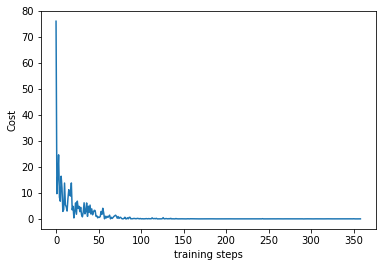

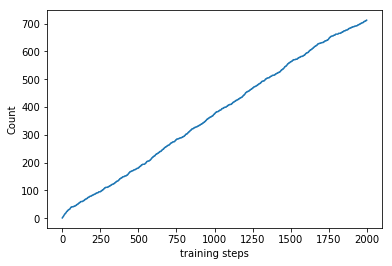

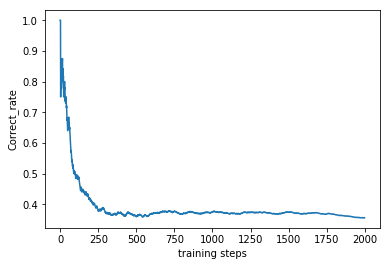

countc的值为：712


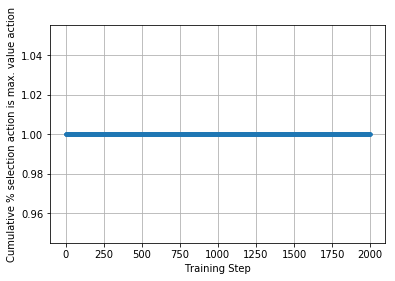

In [6]:
if __name__ == "__main__":
    # maze game
    env = Env()
    
    # For ease of access to DQN config. parameters.
    learningRate = sim['cfg']['dqn']['learningRate']
    rewardDecay = sim['cfg']['dqn']['rewardDecay']
    eGreedy = sim['cfg']['dqn']['eGreedy']
    replaceTargetIter = sim['cfg']['dqn']['replaceTargetIter']
    rewardDecay = sim['cfg']['dqn']['learningRate']    
    memorySize = sim['cfg']['dqn']['memorySize']
    
    RL = DeepQNetwork(env.n_actions, env.n_features,
                      learning_rate=learningRate,
                      reward_decay=rewardDecay,
                      e_greedy=eGreedy,
                      replace_target_iter=replaceTargetIter,
                      memory_size=memorySize,                   
                      )
    
    run()
    RL.plot_cost()
    env.plot_count()
    plt.figure()
    plt.plot(
        np.divide(np.cumsum([1 if i >= 1 else 0 for i in env.count_history]), np.arange(len(env.count_history)) +1),
        '.-')
    plt.xlabel('Training Step')
    plt.ylabel('Cumulative % selection action is max. value action')
    plt.grid(True)
    plt.show()


   


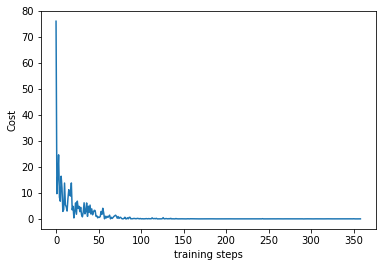

In [7]:
RL.plot_cost()

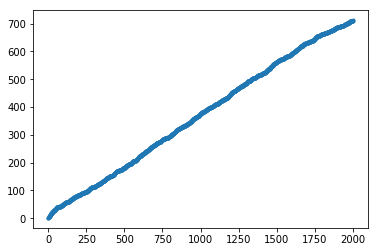

In [8]:
# Trace of number of times selection action is max. value action.
plt.plot(env.count_history, '.-')